# Moon Data Processing Notebook
### Beginning the process of processing the QAG Moon bounce data from Sep 10, 2021
#### Jon Richards - SETI Institute Quantum Astronomy Group
#### This code draws a frequency spectrum from the data

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.fftpack
from scipy.signal import argrelextrema

from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

In [12]:
# Define the data we will use.

# Lower case dish names!
data_file_path = '/Volumes/QAG Disk 1/data/moon_09102021'
#data_files = ['5b_x.dat', '5b_y.dat', '1h_x.dat', '1h_y.dat']
dish_names = ['5b', '1h']

# Dishes 1h and 5b. Their XYZ ECEF coordinates in meters are:
# Lower case dish names!
dishes = [{ 'name' : '1h',
            'x' : '1h_x.dat',
            'y' : '1h_y.dat',
            'XYZ' : [-2524203.0583488033, -4123430.8743299064, 4147685.0269737383] },
          { 'name' : '5b', 
            'x' : '1h_x.dat',
            'y' : '1h_y.dat',
            'XYZ' : [-2523924.2759636184, -4123447.7050980935, 4147836.6033990188] } ]

In [22]:
# Function to create the full path filename for a dish/pol
def get_datafile_fullpath(dish_name, pol):
    """
    Create the full path filename for a dish/pol
    
    Argumants:
        dish_name - name of the dish, like 1h or 5b
        pol       - 'x' or 'y' to specify the polarixation in the filename
        
    Returns:
        The full path filename. None if dish_name is not in the list
    """
    
    if dish_name == None or len(dish_name) != 2:
        return None
    if pol != 'x' and pol != 'y':
        return None
    
    for dish in dishes:
        name = dish.get('name')
        if name == dish_name.lower():
            full_path = f"{data_file_path}/{dish[pol]}"
            return full_path
        
    return None

#print(get_datafile_fullpath('1h', 'x'))
    

/Volumes/QAG Disk 1/data/moon_09102021/1h_x.dat


In [23]:
def readBlock(file, num_samples):
    """ 
    Read the next FFT sized block of 16-bit I/Q data from an opened file.
    
    Arguments:
        file - The reference to the data file, already opened.
        num_samples - The number of 16-bit I/Q samples to read in.
            Example, If you FFT SIZE is 1024, the num_samples should
            be 1024. 2048 16-bit samples (4096 bytes total) will be 
            read and unpacked from the file.
            
        Return - A Numpy array of "num_samples" Complex64 values.
            None if the read is past the end of the file.
    
    """
    # Read the bytes from the file
    data_raw = np.fromfile(file, dtype=np.int16, count=num_samples*2)
    
    # Create a Complex64 Numpy array to hold the values
    data = np.zeros((num_samples,), dtype=np.complex64)
    
    # Reassemble the int16 aray into the Complex64 array.
    # Use a try block to catch the condition where the end of the file
    # has been passed.
    try:
        data[:] = (data_raw[0::2]) + 1j*(data_raw[1::2])
    except:
        return None
    
    return data

In [24]:
def calFreqRangeForAxis(center_hz, bw_hz):
    
    """
    For the X axis tick mark labels, calculate the frequency min/max/center
    
    Arguments:
        center_hz - The center frequency of the signal, in Hertz.
        bw_hz - The bandwidth of the signal, in Hertz.
        
    Returns - A tuple of the 
        min frequency od the signal, in MHz
        max frequency od the signal, in MHz
        center frequency od the signal, in MHz
        
    """
    min_hz = center_hz - bw_hz/2.0
    max_hz = center_hz + bw_hz/2.0
    
    return (min_hz/1000000.0, max_hz/1000000., center_hz/1000000.)

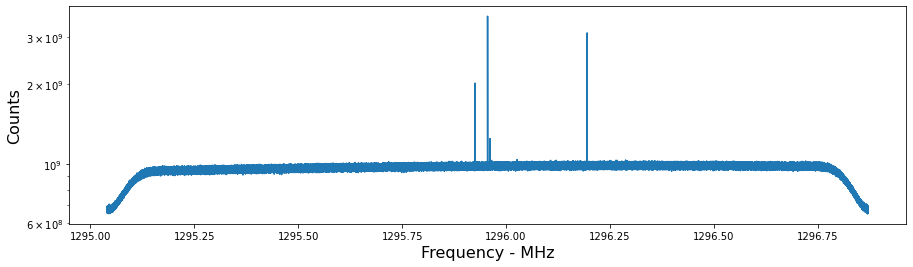

In [9]:
# Perform the FFT and store the result for later plotting.
# The FFT result will be accumulated in a one dimensional Numpy array
# of length equal to the FFT_SIZE

# Define some constants. Here you may wish to change the FFT_SIZE
FFT_SIZE = 1960000
CENTER_FREQ_HZ = 1296000000
BANDWIDTH_HZ   = 1920000
MHZ = 1048576.0

#START_CHAN = 1230880
#END_CHAN = 1313200
START_CHAN = 0
END_CHAN = 1960000
NUM_CHANS = END_CHAN - START_CHAN

# Create an array to hold the accumulation for each bin
fft_acc = np.zeros((NUM_CHANS, ))

# How many FFT_SIZE chunks to process. Ideally we would like to
# process the entire channel, but during code development we may
# wish to read in a smaller number. Reading in the large data files
# takes a lot of time.
NUM = 10000000

# Open the file
file = open(data_file_path, "rb")

file.seek(40000000000)

# Keep a counter of the number of FFT_SIZE length chunks we processed.
count = 0

# Loop through the file. 
for i in range(NUM):
    
    #if count % 100000 == 0:
    #    print(count)
    
    # Read the next block of data from the file
    d = readBlock(file, FFT_SIZE)
    
    # If None is retruned, this signifies we read to the end of the file.
    # Break out of the loop.
    if d is None:
        break
        
    # Perform the FFT
    yf = scipy.fftpack.fft(d, n=FFT_SIZE, axis=0)
    
    # Add the results of the FFTp to the fft_acc Numpy array
    np.add(np.abs(yf[START_CHAN:END_CHAN]), fft_acc, out=fft_acc)
    
    count += 1
    
# Make sure to close the file!
file.close()

# A strange artifact of the FFTp process is that the upper and lower
# halved are swapped. The fftshift swaps them back to the correct order.
fft_acc_temp = scipy.fft.fftshift(fft_acc) 
fft_acc = fft_acc_temp

# Draw a plot of the results
fig, ax = plt.subplots(1,1)

# Get the min/max freqs, in MHz, of the signal
chan_freq_range_info = calFreqRangeForAxis(CENTER_FREQ_HZ, BANDWIDTH_HZ)

# Create a list of the frequencies for the X Axis labels at the tick marks
chan_min_freq_mhz = chan_freq_range_info[0]
freqs_for_xaxis = [(chan_min_freq_mhz + (f*(BANDWIDTH_HZ/FFT_SIZE))/MHZ) for f in range(NUM_CHANS)]

# Label the axex
ax.set_xlabel('Frequency - MHz', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)

# Create the plot
ax.plot(freqs_for_xaxis, fft_acc)

# Make the Y axis be log
ax.set_yscale('log')

# Draw a red vertical line at the center frequency, for a visual reference.
#ax.axvline(x=CENTER_FREQ_HZ/1000000.0, color='red', alpha=0.2)

# Show the plot.
plt.show()



In [25]:
# Now we can refine the plot to look at certain sections

print(FFT_SIZE)
START_CHAN = int(FFT_SIZE * 0.63088)
END_CHAN = int(FFT_SIZE * 0.63093)

#START_CHAN = 1230880
#END_CHAN = 1313200

#START_CHAN = int(START_CHAN + NUM_CHANS*0.0)
#END_CHAN = int(START_CHAN + NUM_CHANS*0.1)
NUM_CHANS = END_CHAN - START_CHAN

print(START_CHAN, END_CHAN, NUM_CHANS)


fig, ax = plt.subplots(1,1)

chan_freq_range_info = calFreqRangeForAxis(CENTER_FREQ_HZ, BANDWIDTH_HZ)
#print(chan_freq_range_info)
ax.ticklabel_format(useOffset=False)
#ax.set_xticks(chan_freq_range_info)

ax.set_xlabel('Frequency - MHz', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)
chan_min_freq_mhz = chan_freq_range_info[0]
#print(f"min={chan_min_freq_mhz}")
freqs_for_xaxis = [(chan_min_freq_mhz + (f*(BANDWIDTH_HZ/FFT_SIZE))/MHZ) for f in range(FFT_SIZE)]
print(len(freqs_for_xaxis[START_CHAN:END_CHAN]), len(fft_acc[START_CHAN:END_CHAN]))
print(len(freqs_for_xaxis), len(fft_acc))

#print(chan_min_freq_mhz)
#print(freqs_for_xaxis[0], freqs_for_xaxis[-1], len(freqs_for_xaxis), len(p2))
#ax.plot(freqs_for_xaxis[START_CHAN:END_CHAN], fft_acc[START_CHAN:END_CHAN])
ax.plot(freqs_for_xaxis[START_CHAN:END_CHAN], fft_acc[START_CHAN:END_CHAN])

ax.set_yscale('log')
#ax.axvline(x=CENTER_FREQ_HZ/1000000.0, color='red', alpha=0.2)

ax.set_title('Frequency Spectrum', fontsize= 16, fontweight="bold")

plt.show()



NameError: name 'FFT_SIZE' is not defined

1960000
1236524 1236622 98
98 98
1960000 1960000


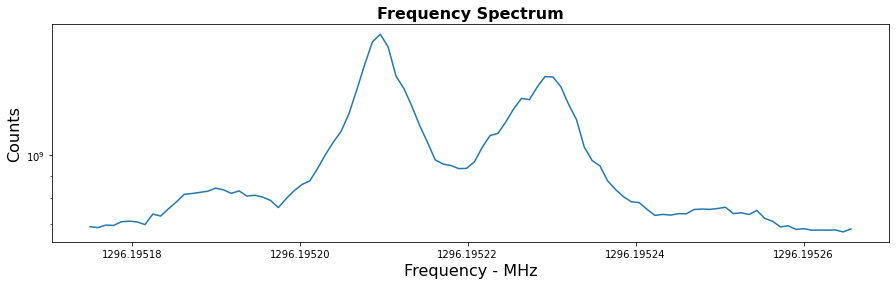

In [59]:
# Now we can refine the plot to look at certain sections

print(FFT_SIZE)
START_CHAN = int(FFT_SIZE * 0.63088)
END_CHAN = int(FFT_SIZE * 0.63093)

#START_CHAN = 1230880
#END_CHAN = 1313200

#START_CHAN = int(START_CHAN + NUM_CHANS*0.0)
#END_CHAN = int(START_CHAN + NUM_CHANS*0.1)
NUM_CHANS = END_CHAN - START_CHAN

print(START_CHAN, END_CHAN, NUM_CHANS)


fig, ax = plt.subplots(1,1)

chan_freq_range_info = calFreqRangeForAxis(CENTER_FREQ_HZ, BANDWIDTH_HZ)
#print(chan_freq_range_info)
ax.ticklabel_format(useOffset=False)
#ax.set_xticks(chan_freq_range_info)

ax.set_xlabel('Frequency - MHz', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)
chan_min_freq_mhz = chan_freq_range_info[0]
#print(f"min={chan_min_freq_mhz}")
freqs_for_xaxis = [(chan_min_freq_mhz + (f*(BANDWIDTH_HZ/FFT_SIZE))/MHZ) for f in range(FFT_SIZE)]
print(len(freqs_for_xaxis[START_CHAN:END_CHAN]), len(fft_acc[START_CHAN:END_CHAN]))
print(len(freqs_for_xaxis), len(fft_acc))

#print(chan_min_freq_mhz)
#print(freqs_for_xaxis[0], freqs_for_xaxis[-1], len(freqs_for_xaxis), len(p2))
#ax.plot(freqs_for_xaxis[START_CHAN:END_CHAN], fft_acc[START_CHAN:END_CHAN])
ax.plot(freqs_for_xaxis[START_CHAN:END_CHAN], fft_acc[START_CHAN:END_CHAN])

ax.set_yscale('log')
#ax.axvline(x=CENTER_FREQ_HZ/1000000.0, color='red', alpha=0.2)

ax.set_title('Frequency Spectrum', fontsize= 16, fontweight="bold")

plt.show()
